## Módulo 3 Unidad 3: Práctica 10 - Regresión Lasso y Ridge.

### 1. Descripción del conjunto de datos.
En primer lugar vamos a cargar los datos de nuestro archivo company.csv en un dataframe de Pandas para proceder a su análisis.



In [3]:
import pandas as pd

df = pd.read_csv('company.csv', sep=',') # creamos dataframe a partir de la lectura del archivo

In [5]:
df.head()

,TV,Radio,Newspaper,Sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,12.0
3,151.5,41.3,58.5,16.5
4,180.8,10.8,58.4,17.9


In [7]:
df.shape # vemos la forma de nuestro dataframe (filas o registros y columnas o atributos)

(200, 4)

In [9]:
df.info() # los tipos de datos de nuestro dataframe son los siguientes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   TV         200 non-null    float64
 1   Radio      200 non-null    float64
 2   Newspaper  200 non-null    float64
 3   Sales      200 non-null    float64
dtypes: float64(4)
memory usage: 6.4 KB


In [11]:
df.nunique() # análisis de valores únicos incluyendo nulos

TV           190
Radio        167
Newspaper    172
Sales        121
dtype: int64

In [13]:
df.describe() # Mostramos las variables numéricas

,TV,Radio,Newspaper,Sales
count,200.000000,200.000000,200.000000,200.000000
mean,147.042500,23.264000,30.554000,15.130500
std,85.854236,14.846809,21.778621,5.283892
min,0.700000,0.000000,0.300000,1.600000
25%,74.375000,9.975000,12.750000,11.000000
50%,149.750000,22.900000,25.750000,16.000000
75%,218.825000,36.525000,45.100000,19.050000
max,296.400000,49.600000,114.000000,27.000000


**Conclusiones previas:**

Se trata de un dataset de tan solo 200 registros y 4 variables numéricas tipo float: TV, Radio, Newspaper y Sales, esta última será la variable objetivo. El dataset no presenta nigún nulo, y tampoco  trae información adicional que nos facilite la descripción de las variables. Podríamos deducir que quizás se trate de un dataset sobre inversión publicitaria (TV, Radio, Newspaper) y su relación con las ventas de un producto o servicio (Sales). Cada fila del dataset podría representar una campaña publicitaria, su inversión en cada medio y las ventas que se generaron durante un determinado periodo.

El dataset podría utilizarse para entender qué canal de publicidad (TV, Radio o Newspaper) impacta más en las ventas y de esta manera predecir futuras ventas en función del presupuesto asignado a cada medio, además de poder optimizar el presupuesto y saber donde invertir para maximar las ventas.

Si analizamos las variables individualmente, TV tiene es el medio publicitario con una mayor inversión media (147.04), seguido de Newspaper (30.55) y por último de la radio (23.26). La desviación estándar de TV también es mayor (85.85) que en el resto de varibles, lo que indica una gran variabilidad de los gastos para este medio.

Si nos fijamos en la variable objetivo Sales, las ventas medias son de 15.13. El 50% de los datos muestra ventas de 16, muy cercano a la media, lo que a priori sugiere una distribución relativamente simétrica.

Para tener un poco más de información antes de trabajar con los modelos vamos a analizar la matriz de correlación:

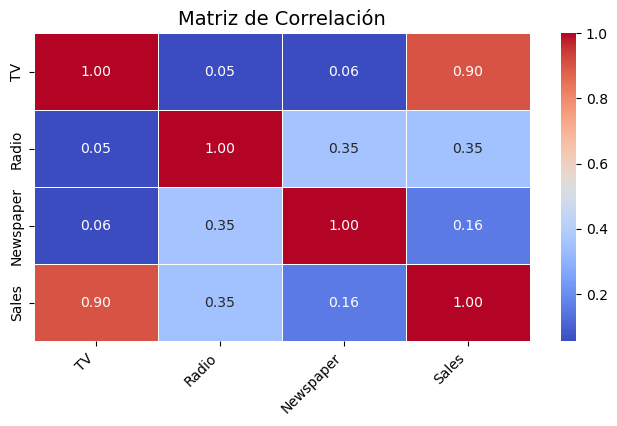

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(8, 4))

sns.heatmap(df.corr(numeric_only=True), 
            annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, 
            ax=ax, cbar=True)
plt.xticks(rotation=45, ha='right') # Rotamos etiquetas del eje X para mejor visualización
plt.title("Matriz de Correlación", fontsize=14)
plt.show()

**Conclusiones:** de la matriz de correlación podemos extraer las siguientes conclusiones:
- Vemos que las relaciones existentes entre las distintas variables son todas positivas.
- Existe una relación muy fuerte entre TV y Sales (0.90), lo que indica que a mayor inversión en publicidad en TV, mayores ventas, lo que sugiere que puede ser el canal más efectivo.
- Tenemos una correlación algo moderada entre Radio y Sales (0.35), lo que puede tener cierta rentabilidad, además de ser un canal de ventas menos costos que la televisión.
- Tenemos una correlación muy débil entre Newspaper y Sales (0.16), por lo que a priori, podemos deducir que invertir en publicidad en periódicos no es muy rentable o es la menos efectiva. Será una variable poco relevante para nuestro modelo.
- Si analizamos la relación entre las variables predictoras, estas no está fuertemente correlacionadas entre sí, lo que es bueno para los modelos de regresión. Únicamente existe una relación algo moderada (0.35) entre Radio y Newspaper, lo que quizás pueda ser explicado que se utilicen estos canales de publicidad de manera combinada en las estrategias de publicidad.

### 2. División del dataset en conjuntos de entrenamiento y prueba.
En primer lugar procedemos a importar las librerías y utilizaremos 'train_test_split' par la división de nuestros datos.

In [20]:
# Importamos librerías
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import numpy as np

In [22]:
X = df.drop(columns=['Sales']) # Asignamos variables predictoras a X

y = df['Sales'] # Asiganmos variable objetivo a y

# Dividimos el conjunto de datos en entrenamiento (75%) y prueba (25%).
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Obtenemos los nombres de las columnas del dataframe antes de escalar (cuando escalamos obtenemos un array de numpy)
columnas = df.drop(columns=['Sales']).columns # esto lo utilizaremos más adelante para los gráficos

# Escalamos sólo con datos de entrenamiento
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### 3. Aplicación del modelo Regresión Lineal.
Antes de ir con los modelos de Regresión Ridge y Lasso, vamos a ver el resultado con el módelo de Regresión Lineal, utilizando las métricas MSE y R².

In [25]:
model = LinearRegression() # Creamos el modelo
model.fit(X = X_train, y = y_train) # Ajustamos el modelo

LinearRegression()

In [27]:
# Realizamos predicción de nuestra variable objetivo a partir de nuestra variable predictora de entrenamiento X_test
y_pred = model.predict(X_test)

In [29]:
# Evaluamos el resultado de nuestro modelo con las métricas MSE y R2
mse = mean_squared_error(y_test, y_pred) # cálculo del error cuadrático medio
r2 = r2_score(y_test, y_pred) # cálculo del coeficiente de determinación
print('Error cuadrático medio MSE: ', mse)
print('R² score: ', r2)

Error cuadrático medio MSE:  2.4040674447118904
R² score:  0.9115647723992757


**Conclusiones:** el error cuadrático medio mide la media de los errores al cuadrado entre las predicciones y los valores reales. Cuanto más bajo será mejor. Nuestro rango de 'Sales' está entre 1.6 y 27 según vimos en el análisis previo del dataset en el apartado anterior, lo que un error medio de 2.4 es bastante aceptable. En cuanto al coeficiente de determinación (R² score), este nos mide qué proporción de la variabilidad de 'Sales' se explica por las variables predictoras. Cuanto más cerca de 1, mejor, en nuestro caso es 0.91, lo que indica que explica el 91% de la varianza de las ventas, lo que es un muy buen resultado.

Vamos a analizar los coeficientes para este modelo mediante un gráfico tallos (stem plot), ya que es ideal para visualizar los valores individuales de los coeficientes, destacando su magnitud y signo, permitiéndonos comparar visualmente que variables tienen mayor impacto, identificar los coeficientes con poca influencia (valores cercanos a cero) y ver clarametne si el efecto es positivo o negativo.

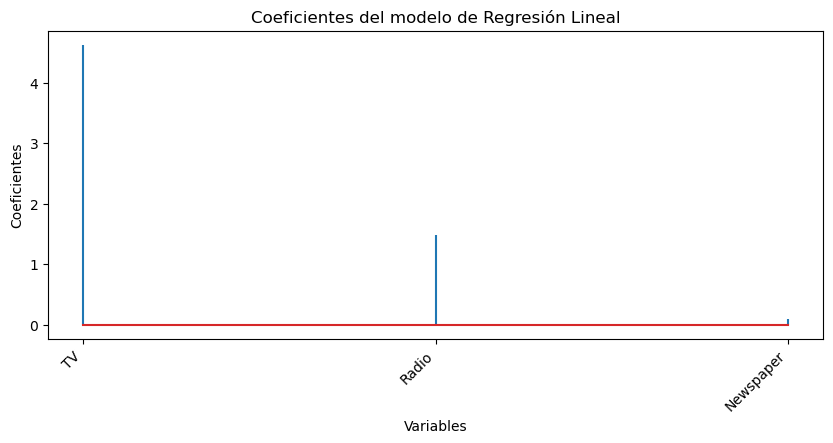

In [33]:
# Creamos un dataframe con el nombre de las variables y los coeficientes
df_coeficientes = pd.DataFrame(
                        {'predictor': columnas,
                         'coef': model.coef_.flatten()}
                  )
# Creamos el gráfico de tallos
fig, ax = plt.subplots(figsize=(10, 4))
ax.stem(df_coeficientes.predictor, df_coeficientes.coef, markerfmt=' ')
plt.xticks(rotation=45, ha='right') # Rotamos etiquetas del eje X para mejor visualización
ax.set_xlabel('Variables')
ax.set_ylabel('Coeficientes')
ax.set_title('Coeficientes del modelo de Regresión Lineal');

**Conclusiones:** cada coeficiente indica cuánto se espera que aumenten las ventas por cada unidad adicional de inversión en ese medio, manteniendo las otras variables constantes. La TV se confirma como la variable más influyente, ya que por cada aumento de una desviación estándar en el gasto de publicidad en TV, las ventas aumentan 4.5 unidades en la escala de Ventas. Radio tiene un impacto moderado, con 1.5. Vemos que Newspaper tiene una influencia casi nula. Esto puede indicar que invertir en periódicos no tiene un impacto significativo en las ventas. Por tanto, esta variable es posible que sea penalizada y posiblemente eliminada cuando apliquemos Lasso.
Por último, vemos que todos estos valores corroboran los datos vistos en la matriz de correlación.

### 4. Aplicación del modelo de Regresión Ridge con validación cruzada.
Vamos aplicar ahora el Modelo Ridge con validación cruzada, muy útil para evitar sobreajuste. Para ello usamos un Pipeline con el escalado dentro, así lo realizamos dentro del proceso de validación cruzada. Una vez entrenado y evaluado el modelo extraeremos el valor óptima de alpha y además calcularemos las métricas de error cuadrático medio (MSE) y R² en el conjunto de prueba.

In [37]:
# Exploramos una amplia gama de alphas: 100 valores entre 10^-3 y 10^3
alphas = np.logspace(-3, 3, 100)  

# Creamos un pipeline: escalado + modelo
model_ridge_cv = make_pipeline(
    StandardScaler(),
    RidgeCV(alphas=alphas, cv=5)  # validación cruzada con 5 folds
)

# Entrenamos el modelo
model_ridge_cv.fit(X_train, y_train)

# Predecimos en test
y_pred_ridgecv = model_ridge_cv.predict(X_test)

# Evaluamos rendimiento
mse_ridge = mean_squared_error(y_test, y_pred_ridgecv)
r2_ridge = r2_score(y_test, y_pred_ridgecv)

# Extraemos el mejor alpha y los coeficientes
best_alpha = model_ridge_cv.named_steps['ridgecv'].alpha_
coefs_ridge_cv = model_ridge_cv.named_steps['ridgecv'].coef_

# Resultados
print('Mejor alpha seleccionado por RidgeCV:', best_alpha)
print('Error cuadrático medio (MSE):', mse_ridge)
print('R² score:', r2_ridge)
print('Valor óptimo de alpha:', best_alpha)

Mejor alpha seleccionado por RidgeCV: 0.9326033468832199
Error cuadrático medio (MSE): 2.410579343261626
R² score: 0.9113252278591982
Valor óptimo de alpha: 0.9326033468832199


Vamos a analizar cómo varían los coeficientes de las características predictoras cuando variamos el valor de alpha. Para ello vamos a visualizar los coeficientes en función del parámetro alpha, para comprender mejor el efecto de la regularización en Ridge. Tenemos que tener una cosa en cuenta. Estamos usando el escalado de los datos dentro de Pipeline, por lo que ahora debemos realizar el escalado manualmete antes de hacer nuestro bucle de alphas en nuestros datos de entrenamiento.

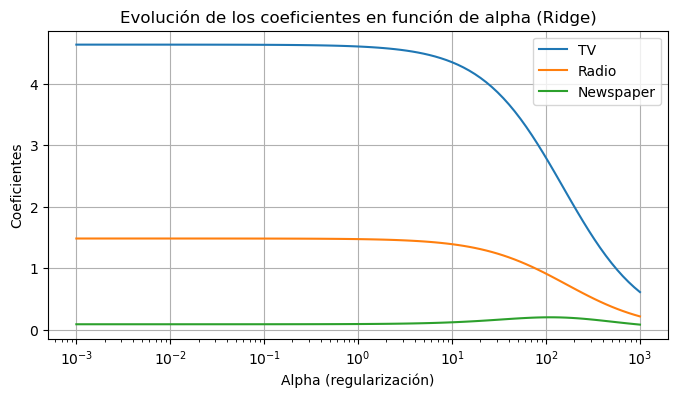

In [40]:
# Escalado manual para entrenar el modelo en un bucle posteriormente (RidgeCV usa datos escalados)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Lista de coeficientes vacía
coefs = []

# Entrenamos un modelo temporal Ridge por cada alpha y guardamos sus coeficientes
for alpha in alphas: # recordamos que alphas = np.logspace(-3, 3, 100)
    modelo_temp = Ridge(alpha=alpha, fit_intercept=False)
    modelo_temp.fit(X_train_scaled, y_train)
    coefs.append(modelo_temp.coef_)

# Convertimos la lista de coeficientes a array para graficar fácilmente
coefs = np.array(coefs)

# Gráfico
fig, ax = plt.subplots(figsize=(8, 4))

# Trazamos una línea por cada variable
for i, nombre in enumerate(X.columns):
    ax.plot(alphas, coefs[:, i], label=nombre)
ax.set_xscale('log')
ax.set_xlabel('Alpha (regularización)')
ax.set_ylabel('Coeficientes')
ax.set_title('Evolución de los coeficientes en función de alpha (Ridge)')
plt.legend() # Añadimos una leyenda
plt.axis('tight')
plt.grid(True)
plt.show()

**Conclusión:** en el gráfico anterior podemos ver la evolución de los coeficientes para los distintos valores de alpha. Nuestro valor óptimo es 0.93, es decir, muy cercano al 10^0 = 1, justo donde vemos en el gráfico que empiezan disminuir los coeficientes de las distintas variables. Vemos que con Ridge a medida que aumentamos alpha los valores se aproxima a cero, pero nunca llegan a ser 0.

Por último, vamos a analizar un con gráfico de tallos los coeficientes para nuestro valor de alpha óptimo calculado anteriormente: 0.93.

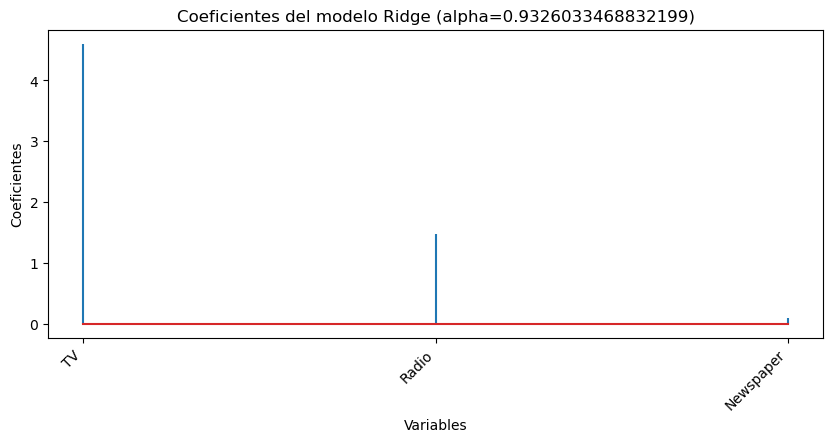

In [44]:
# Creamos DataFrame con coeficientes
df_coefs_ridge = pd.DataFrame({
    'predictor': columnas,
    'coef': coefs_ridge_cv
})

# Gráfico de tallos
fig, ax = plt.subplots(figsize=(10, 4))
ax.stem(df_coefs_ridge.predictor, df_coefs_ridge.coef, markerfmt=' ')
plt.xticks(rotation=45, ha='right')
ax.set_xlabel('Variables')
ax.set_ylabel('Coeficientes')
ax.set_title(f'Coeficientes del modelo Ridge (alpha={best_alpha})')
plt.show()

**Conclusiones:** vemos que los valores son similares a los coeficientes obtenidos en el modelo de regresión lineal. Esto se puede deber que nuestro modelo no se beneficia de la regularización, dado que tenemos muy pocos predictores, tan solo 3, y que no hay una correlación entre variables predictoras significativa. Nuestro modelo inicial puede ser bueno y no estar sobreajustando.

### 5. Aplicación del modelo de Regresión Lasso con validación cruzada.
Vamos aplicar ahora el Modelo Lasso con validación cruzada. Usaremos de nuevo un Pipeline con el escalado dentro. Una vez entrenado y evaluado el modelo extraeremos el valor óptimo de alpha y además calcularemos las métricas de error cuadrático medio (MSE) y R² en el conjunto de prueba.

In [48]:
# Creamos un pipeline: escalado + modelo LassoCV
model_lasso_cv = make_pipeline(
    StandardScaler(),
    LassoCV(alphas=alphas, cv=5, max_iter=10000)  # max_iter para evitar warning por convergencia
)

# Entrenamiento
model_lasso_cv.fit(X_train, y_train)

# Predicción
y_pred_lassocv = model_lasso_cv.predict(X_test)

# Evaluación
mse_lasso = mean_squared_error(y_test, y_pred_lassocv)
r2_lasso = r2_score(y_test, y_pred_lassocv)

# Mejor alpha y coeficientes
best_alpha_lasso = model_lasso_cv.named_steps['lassocv'].alpha_
coefs_lasso_cv = model_lasso_cv.named_steps['lassocv'].coef_

# Resultados
print('Mejor alpha seleccionado por LassoCV:', best_alpha_lasso)
print('Error cuadrático medio Lasso (MSE):', mse_lasso)
print('R² score Lasso: ', r2_lasso)
print('Valor óptimo de alpha:', best_alpha_lasso)

Mejor alpha seleccionado por LassoCV: 0.049770235643321115
Error cuadrático medio Lasso (MSE): 2.414571531472802
R² score Lasso:  0.9111783725478562
Valor óptimo de alpha: 0.049770235643321115


Vamos a analizar cómo varían los coeficientes de las características predictoras cuando variamos el valor de alpha para comprender mejor el efecto de la regularización en Lasso.

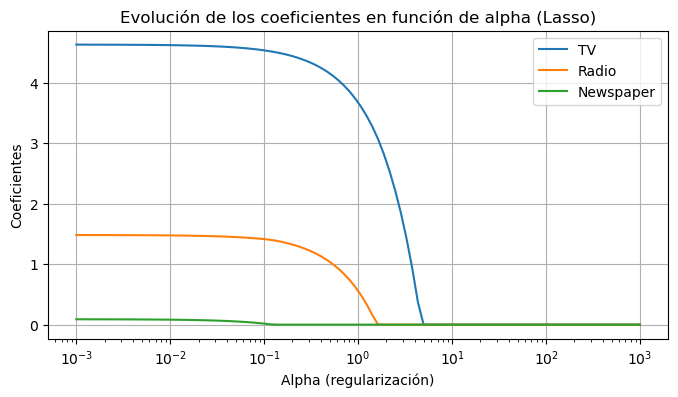

In [51]:
# Escalado manual
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Evolución de coeficientes con alpha
coefs_lasso_path = []
for alpha in alphas:
    modelo_temp = Lasso(alpha=alpha, fit_intercept=False, max_iter=10000)
    modelo_temp.fit(X_train_scaled, y_train)
    coefs_lasso_path.append(modelo_temp.coef_)

coefs_lasso_path = np.array(coefs_lasso_path)

# Gráfico de evolución
fig, ax = plt.subplots(figsize=(8, 4))
for i, nombre in enumerate(X.columns):
    ax.plot(alphas, coefs_lasso_path[:, i], label=nombre)
ax.set_xscale('log')
ax.set_xlabel('Alpha (regularización)')
ax.set_ylabel('Coeficientes')
ax.set_title('Evolución de los coeficientes en función de alpha (Lasso)')
plt.legend() # Agregamos leyenda
plt.axis('tight')
plt.grid(True)
plt.show()

Por último, vamos a analizar un con gráfico de tallos los coeficientes para nuestro valor de alpha óptimo calculado anteriormente: 0.0498.

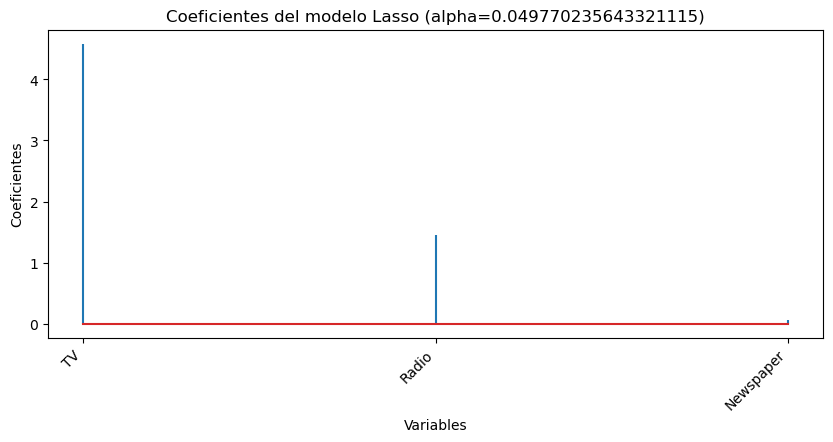

In [54]:
# DataFrame con coeficientes finales
df_coefs_lasso = pd.DataFrame({
    'predictor': columnas,
    'coef': coefs_lasso_cv
})

# Gráfico de tallos
fig, ax = plt.subplots(figsize=(10, 4))
ax.stem(df_coefs_lasso.predictor, df_coefs_lasso.coef, markerfmt=' ')
plt.xticks(rotation=45, ha='right')
ax.set_xlabel('Variables')
ax.set_ylabel('Coeficientes')
ax.set_title(f'Coeficientes del modelo Lasso (alpha={best_alpha_lasso})')
plt.show()

**Conclusiones:** Lasso aplica reducción de coeficientes a cero si alguna variable no aporta al modelo. En nuestro caso, vemos como esto sucede con Newspaper.

A continuación vamos a realizar un resumen de las métricas obtenidas con los modelos para extraer las conclusiones:

In [58]:
print('Error cuadrático medio Regresión Lineal (MSE): ', round(mse, 4))
print('R² score Regresión Lineal: ', round(r2, 4))

print('Error cuadrático medio Ridge (MSE) para su alpha óptima:', round(mse_ridge, 4))
print('R² score Ridge para su alpha óptima: ', round(r2_ridge, 4))

print('Error cuadrático medio Lasso (MSE) para su alpha óptima:', round(mse_lasso, 4))
print('R² score Lasso para su alpha óptima: ', round(r2_lasso, 4))

Error cuadrático medio Regresión Lineal (MSE):  2.4041
R² score Regresión Lineal:  0.9116
Error cuadrático medio Ridge (MSE) para su alpha óptima: 2.4106
R² score Ridge para su alpha óptima:  0.9113
Error cuadrático medio Lasso (MSE) para su alpha óptima: 2.4146
R² score Lasso para su alpha óptima:  0.9112


**Conclusión:** nuestro dataset es demasiado simple, de ahí que no veamos una diferencia apreciable en los resultados obtenidos tras aplicar regularización con Ridge o Lasso.

**Conclusiones finales:**
La **regularización** modifica la forma en que el modelo ajusta los coeficientes, añadiendo una penalización por su magnitud al proceso de entrenamiento. Esto nos puede proporcionar varios beneficios:
- reduce la magnitud de los coeficientes, evitando que el modelo se ajuste en exceso a los datos de entrenamiento.
- aumenta la generalización, algo ideal, ya que mejora el rendimiento en datos no vistos en el entrenamiento.
- controla el sobreajuste, especialmente cuando hay muchas variables o ruido.

En **Ridge**, los coeficientes tienden a cero suavemente conforme aumenta alpha, pero rara vez son exactamente cero, como pudimos ver en los gráficos anteriores. Las variables irrelevantes tendrán coeficientes muy pequeños, pero siguen formando parte del modelo. Este modelo es bueno cuando todas las varaibles aportan algo o cuando hay multicolinealidad, es decir, que dos o más variables presente una alta correlación entre sí.

En cambio en **Lasso**, muchos coeficientes se hacen exactamente cero cuando alpha crece, lo que es muy útil para selección de variables cuando tenemos un dataset con muchas características predictoras, ya que elimina automáticamente las variables menos importantes. Por tanto, Lasso es bueno cuando sólo unas pocas variables de nuestro dataset son relevantes y estamos buscando un modelo más simple y explicativo, y queremos eliminar ruido.

En cuanto a rendimiento, para nuestro dataset en particular, los modelos utilizados presentan un rendimiento similar. Para ver realmente las diferencias tendríamos que tener un dataset más complejo, con más variables predictoras, que nos permitiera apreciar las virtudes de los distintos modelos en cuanto a los resultados de rendimiento.